<a href="https://colab.research.google.com/github/gagan3012/gsoc-ml/blob/master/Test_II_Learning_the_DM_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import random

In [2]:
!git clone https://github.com/ML4SCI/ML4SCI_GSoC

Cloning into 'ML4SCI_GSoC'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 21), reused 46 (delta 13), pack-reused 0
Unpacking objects: 100% (75/75), done.
Checking out files: 100% (36/36), done.


In [3]:
fname = '/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/lenses.tgz'
extract_path = '/content'

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall(extract_path)
    tar.close()

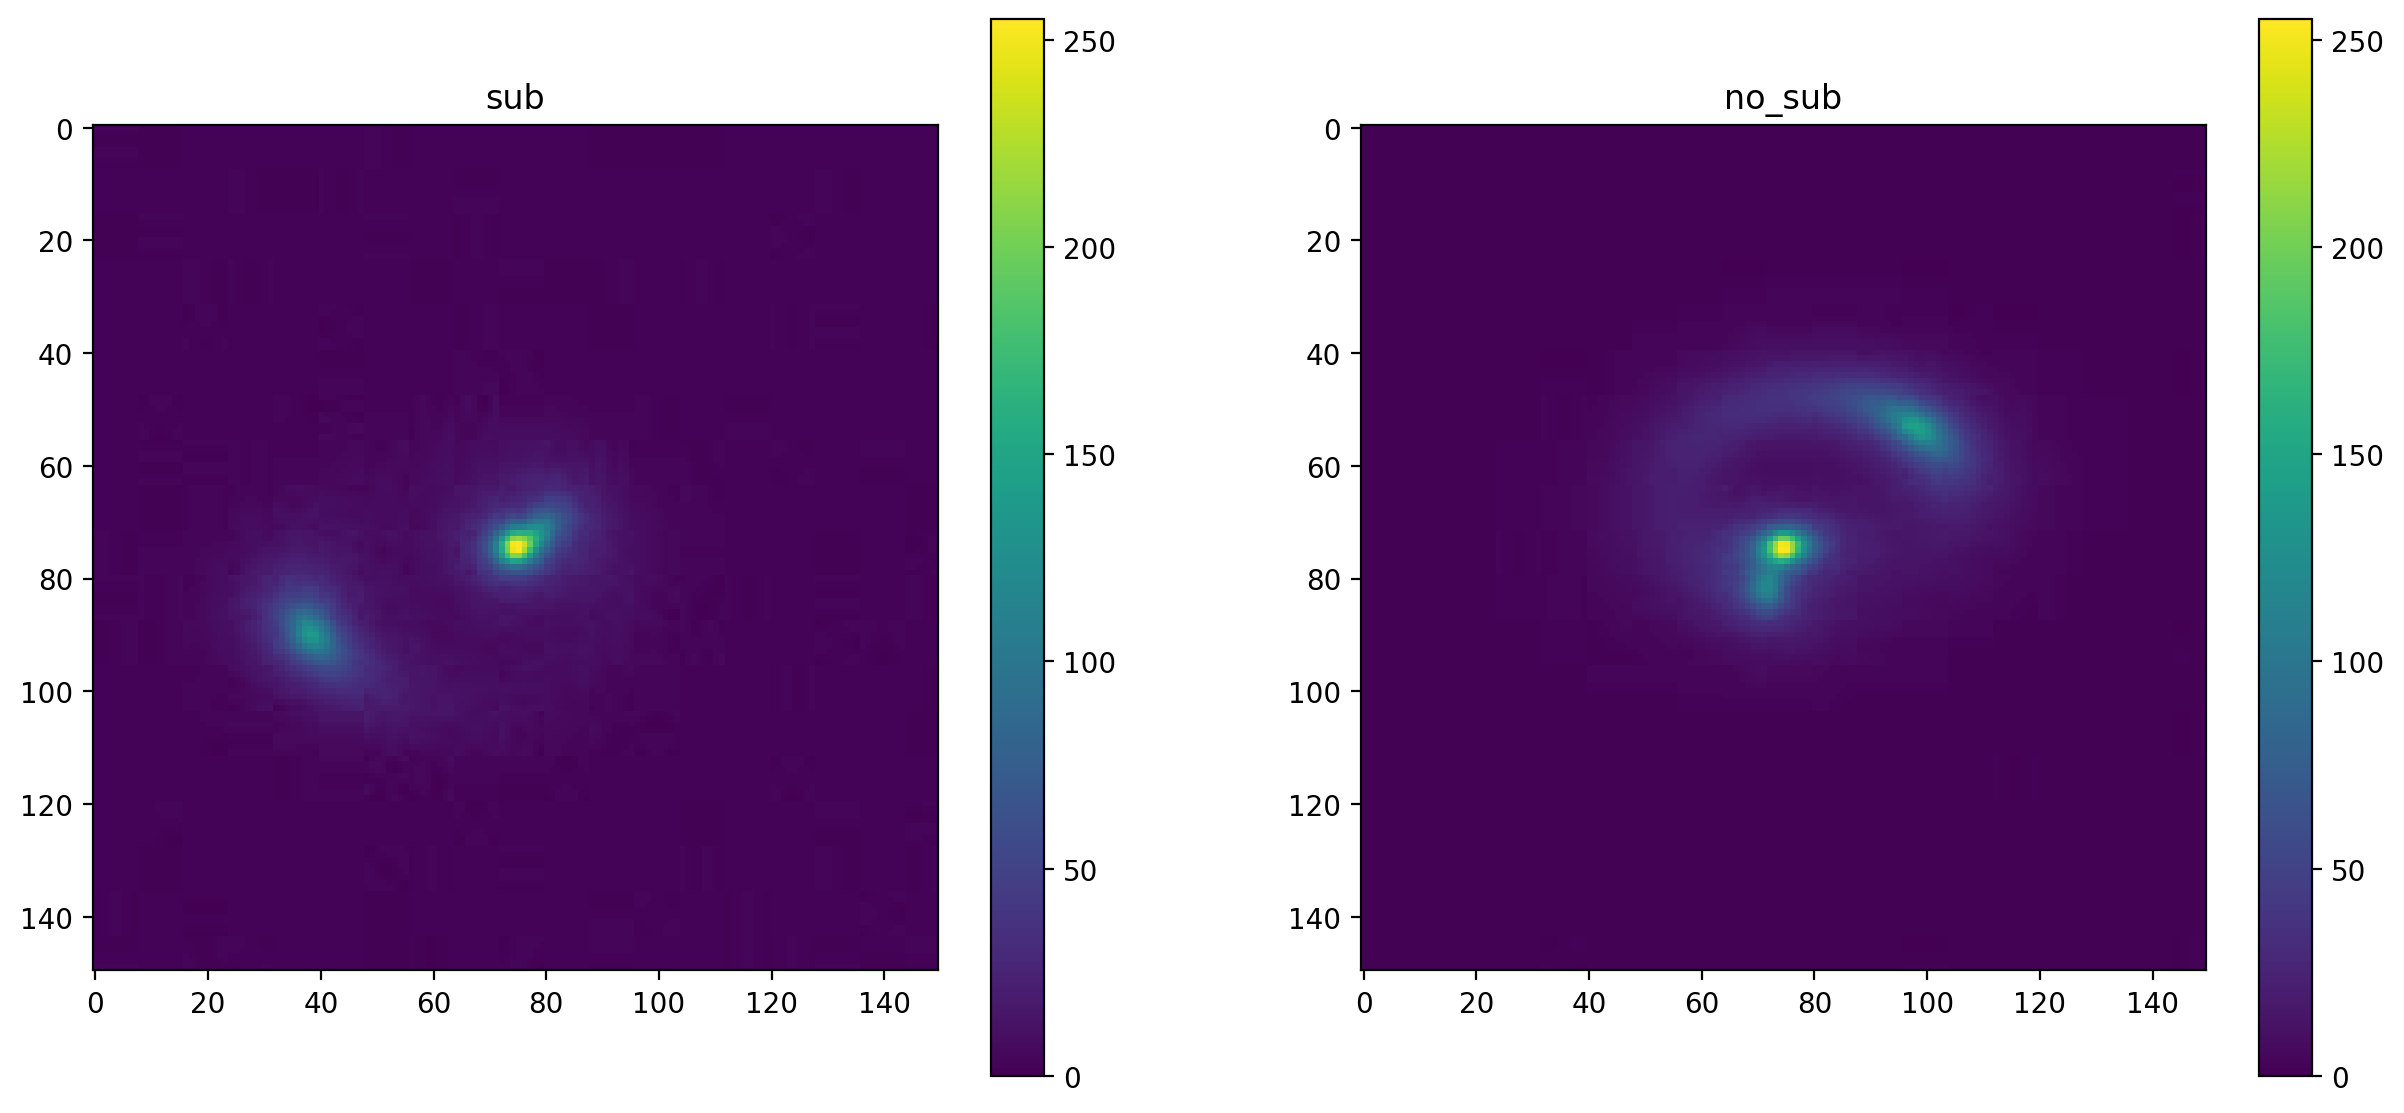

In [8]:
lenses_dir = '/content/lenses'

sub_dir = os.path.join(lenses_dir, 'sub')
no_sub_dir = os.path.join(lenses_dir, 'no_sub')

# Ploting random images 
sub_img = PIL.Image.open(os.path.join(sub_dir,random.choice(os.listdir(sub_dir))))
no_sub_img = PIL.Image.open(os.path.join(no_sub_dir,random.choice(os.listdir(no_sub_dir))))

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
im1 = axs[0].imshow(sub_img)
axs[0].set_title('sub')
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(no_sub_img)
axs[1].set_title('no_sub')
plt.colorbar(im2, ax=axs[1])
plt.show()

In [10]:
dataset = ImageFolder(lenses_dir)

In [15]:
print(dataset.class_to_idx)

{'no_sub': 0, 'sub': 1}


In [16]:
class LensDataset(Dataset):
    def __init__(self, dataset, phase='train'):
        self.dataset = dataset
        self.phase = phase

    def __getitem__(self, idx):
        if self.phase == 'train':
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.RandomRotation(5),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.Resize((150, 150)),
                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                            transforms.Grayscale(num_output_channels=1)
                                            ])
            
            data = transform(dataset[idx][0])
            return data

        elif self.phase == 'eval':
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Resize((150, 150)),
                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                            transforms.Grayscale(num_output_channels=1)
                                            ])
            
            data = transform(dataset[idx][0])
            label = dataset[idx][1]
            return data, label

    def __len__(self):
        return len(dataset)

In [17]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [18]:
BATCH_SIZE = 64

train_dataset = LensDataset(train_dataset, 'train')
test_dataset = LensDataset(test_dataset, 'eval')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
